In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/ABIDE/") 

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/ABIDE/')

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from neuralCombat import *
import pandas as pd
from sklearn import svm
import joblib
import openpyxl
from openpyxl import load_workbook
import os
import scipy.io as scio
import argparse
import numpy as np
import time
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
import torchvision.utils as vutils
from os.path import join
from os import listdir
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import DataLoader
from collections import OrderedDict
import nibabel as nib
import matplotlib.pyplot as plt
import cv2 as cv
from os import path
import shutil
import scipy.stats
import scipy.ndimage
import random
import torch.nn.init as init
import torch.nn.functional as F
import sys
import math
from functools import reduce
import operator
from scipy.interpolate import interp1d
from torch.optim import lr_scheduler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import RFE

def feature_selection_fMRI(matrix, labels, train_ind, fnum):
    """
        matrix       : feature matrix (num_subjects x num_features)
        labels       : ground truth labels (num_subjects x 1)
        train_ind    : indices of the training samples
        fnum         : size of the feature vector after feature selection 

    return:
        x_data      : feature matrix of lower dimension (num_subjects x fnum)
    """

    estimator = RidgeClassifier()
    selector = RFE(estimator, n_features_to_select=fnum, step=100, verbose=1)

    featureX = matrix[train_ind, :]
    featureY = labels[train_ind]
    selector = selector.fit(featureX, featureY.ravel())

    return selector
def feature_selection_sMRI(matrix, labels, train_ind, fnum):
    """
        matrix       : feature matrix (num_subjects x num_features)
        labels       : ground truth labels (num_subjects x 1)
        train_ind    : indices of the training samples
        fnum         : size of the feature vector after feature selection 

    return:
        x_data      : feature matrix of lower dimension (num_subjects x fnum)
    """

    estimator = RidgeClassifier()
    selector = RFE(estimator, n_features_to_select=fnum, step=10, verbose=1)

    featureX = matrix[train_ind, :]
    featureY = labels[train_ind]
    selector = selector.fit(featureX, featureY.ravel())

    return selector


def get_index(lst=None, item=''):
	return [i for i in range(len(lst)) if lst[i] == item]

def flatten_one(length, img):
	'''
	  In some situations, the dimension on z-axis of images are smaller than
	  the dimension of z-axis of patches, this function will be used to pad
	'''

	one_line = np.zeros((1, int(length)))
	position = 0
	for i in range(img.shape[0]):  # column
		for j in range(i + 1, img.shape[1]):  # row
			one_line[0, position] = img[j, i]
			position = position + 1
	return one_line


def get_ids(num_subjects=None,dir_path=''):
	"""
	return:
		subject_IDs    : list of all subject IDs
	"""
	subject_IDs = np.genfromtxt(os.path.join(dir_path, 'subject_IDs.txt'), dtype=str)

	if num_subjects is not None:
		subject_IDs = subject_IDs[:num_subjects]

	return subject_IDs



In [ ]:
########################################### Load Data ###############################################
#####################################################################################################
#####################################################################################################
fMRI_atlas = 'CC200'  # AAL or CC200
combat_fMRI = True    # True or False
combat_sMRI = True

if combat_sMRI == False:
  save_combat_sMRI = '/without_ComBat/'
else:
  save_combat_sMRI = '/with_ComBat/'

# fMRI path
save_path = '/content/drive/MyDrive/ABIDE/save_models/CC200_sMRI/'+ save_combat_sMRI
root_path_fMRI = '/content/dataset'
if os.path.exists(root_path_fMRI):
  shutil.rmtree(root_path_fMRI) 
shutil.copytree('/content/drive/MyDrive/ABIDE/' + fMRI_atlas + '/original/', root_path_fMRI) 
label_dir = '/content/drive/MyDrive/ABIDE/phenotypic_image_quality'

# sMRI path
localDir = '/content/sMRI_dataset/'
if os.path.exists(localDir):
  shutil.rmtree(localDir) 
os.makedirs(localDir)
!unzip '/content/drive/MyDrive/ABIDE/freesurfer_stats.zip' -d '/content/sMRI_dataset'
localDir = localDir + 'freesurfer_stats/'


k_fold = 5
new_number_features_fMRI = 5000
new_number_features_sMRI = 1435
new_number_features_combine = 6000
number_samples = 871
useless_samples = ['51334']
if fMRI_atlas == 'AAL':
  image_size = [116, 116]
else:
  image_size = [200, 200]
scaler = True


age_name = 'ages.mat'
gender_name = 'genders.mat'
label_name = 'ABIDE_label_871.mat'
label = scio.loadmat(os.path.join(label_dir, label_name))
label = label['label'][0]
labels = np.zeros(number_samples - len(useless_samples))
site_name = 'sites.mat'
site = scio.loadmat(os.path.join(label_dir, site_name))
all_sites = site['sites']
for i in range(len(all_sites)):
	site = all_sites[i]
	all_sites[i] = site.replace(' ', '')
unique_sites = np.unique(all_sites)
sites = []
unique_sites = list(unique_sites)

gender = scio.loadmat(os.path.join(label_dir, gender_name))
gender = gender['genders']
genders = np.zeros((number_samples - len(useless_samples), 1))

age = scio.loadmat(os.path.join(label_dir, age_name))
age = age['ages']
ages = np.zeros((number_samples - len(useless_samples), 1))

subject_IDs = get_ids(number_samples,dir_path=label_dir)
subject_IDs = subject_IDs.tolist()
length = image_size[0] * (image_size[1]-1) / 2
fMRI_images = np.zeros((number_samples - len(useless_samples), int(length)))

position = 0
print('constructing fMRI features')
for i in range(number_samples):
  subject_name = subject_IDs[i]
  if subject_name in useless_samples:
    subject_index = get_index(lst=subject_IDs, item=subject_name)
    print('The index for sample ' + subject_name + ' is : ', subject_index)
  else:
    image_name = subject_name + '.mat'
    subject_index = get_index(lst=subject_IDs, item=subject_name)
    image = scio.loadmat(os.path.join(root_path_fMRI, image_name))
    img = image['connectivity']

    idx = np.triu_indices_from(img, 1)
    fMRI_images[position, :] = img[idx]
    sites.append(all_sites[subject_index[0]])
    labels[position] = label[subject_index[0]]
    genders[position] = int(gender[subject_index[0]]) + 1
    ages[position] = float(age[subject_index[0]].replace(' ', ''))
    position = position + 1

if scaler == True:
	fMRI_images = StandardScaler().fit_transform(fMRI_images)

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/brainvol.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.a2009s.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.DKTatlas.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.pial.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.BA_exvivo.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.BA_exvivo.thresh.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.curv.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.w-g.pct.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/rh.aparc.a2009s.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/rh.aparc.DKTatlas.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/rh.aparc.pial.stats  
  inflating: /c

In [ ]:
############################################### Load sMRI ###############################################################
############################################### Load sMRI ###############################################################
############################################### Load sMRI ###############################################################
############################################### Load Desikan_Killiany_features
left = 'lh.aparc.stats'
right = 'rh.aparc.stats'
number_roi = 68
feature_list = ['NumVert', 'SurfArea', 'GrayVol', 'ThickAvg', 'ThickStd', 'MeanCurv', 'GausCurv', 'FoldInd', 'CurvInd']
names = ['StructName', 'NumVert', 'SurfArea', 'GrayVol', 'ThickAvg', 'ThickStd', 'MeanCurv', 'GausCurv', 'FoldInd', 'CurvInd']
skiprows= list(range(0,61))
Desikan_Killiany_features = np.zeros((number_samples - len(useless_samples), number_roi * len(feature_list)))


position = 0
print('constructing Desikan-Killiany Atlas features')
for i in range(number_samples):
  subject_name = subject_IDs[i]
  if subject_name in useless_samples:
    subject_index = get_index(lst=subject_IDs, item=subject_name)
    print('The index for sample ' + subject_name + ' is : ', subject_index)
  else:
    table_left = pd.read_table(localDir + subject_name + '/' + left, sep='\s+', names=names,
						  skiprows=skiprows)
    table_right = pd.read_table(localDir + subject_name + '/' + right, sep='\s+', names=names,
						  skiprows=skiprows)

    for j in range(len(feature_list)):
      feature_name = feature_list[j]
      left_features = table_left[feature_name].values.tolist()
      right_features = table_right[feature_name].values.tolist()
      all_features = left_features + right_features
      if len(all_features) != number_roi:
       print('The sample ' + subject_name + ' has mistake!')
      all_features = np.array(all_features)
      Desikan_Killiany_features[position, j*number_roi : (j+1)*number_roi] = all_features
    position = position + 1

if scaler == True:
	for i in range(len(feature_list)):
		Desikan_Killiany_features[:, i * number_roi: (i+1) * number_roi] = StandardScaler().fit_transform(Desikan_Killiany_features[:, i * number_roi: (i+1) * number_roi])

print('finished')

############################################### Load aseg features
print('constructing aseg features')
number_roi_aseg = 45
aseg = 'aseg.stats'
feature_list_aseg = ['Number of Voxels', 'Volume', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
names_aseg = ['ColHeader Index', 'Segmentation Id ', 'Number of Voxels', 'Volume', 'Structure Name', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
skiprows_aseg= list(range(0,79))
aseg_features = np.zeros((number_samples - len(useless_samples), number_roi_aseg * len(feature_list_aseg)))

position = 0
for i in range(number_samples):
	subject_name = subject_IDs[i]
	if subject_name in useless_samples:
		subject_index = get_index(lst=subject_IDs, item=subject_name)
		print('The index for sample ' + subject_name + ' is : ', subject_index)
	else:
		table_left = pd.read_table(localDir + subject_name + '/' + aseg, sep='\s+', names=names_aseg,
						  skiprows=skiprows_aseg)
		for j in range(len(feature_list_aseg)):
			feature_name = feature_list_aseg[j]
			left_features = table_left[feature_name].values.tolist()
			if len(left_features) != number_roi_aseg:
				print('The sample ' + subject_name + ' has mistake!')
			all_features = np.array(left_features)
			aseg_features[position, j*number_roi_aseg : (j+1)*number_roi_aseg] = all_features
		position = position + 1

if scaler == True:
	for i in range(len(feature_list_aseg)):
		aseg_features[:, i * number_roi_aseg: (i+1) * number_roi_aseg] = StandardScaler().fit_transform(aseg_features[:, i * number_roi_aseg: (i+1) * number_roi_aseg])
print('finished')

############################################### Load wmparc features
number_roi_wmparc = 70
wmparc = 'wmparc.stats'
feature_list_wmparc = ['Number of Voxels', 'Volume', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
names_wmparc = ['ColHeader Index', 'Segmentation Id ', 'Number of Voxels', 'Volume', 'Structure Name', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
skiprows_wmparc= list(range(0,65))
wmparc_features = np.zeros((number_samples - len(useless_samples), number_roi_wmparc * len(feature_list_wmparc)))

print('constructing wmparc features')
position = 0
for i in range(number_samples):
	subject_name = subject_IDs[i]
	if subject_name in useless_samples:
		subject_index = get_index(lst=subject_IDs, item=subject_name)
		print('The index for sample ' + subject_name + ' is : ', subject_index)
	else:
		table_left = pd.read_table(localDir + subject_name + '/' + wmparc, sep='\s+', names = names_wmparc,
						  skiprows=skiprows_wmparc)
		for j in range(len(feature_list_wmparc)):
			feature_name = feature_list_wmparc[j]
			left_features = table_left[feature_name].values.tolist()
			if len(left_features) != number_roi_wmparc:
				print('The sample ' + subject_name + ' has mistake!')
			all_features = np.array(left_features)
			wmparc_features[position, j*number_roi_wmparc : (j+1)*number_roi_wmparc] = all_features
		position = position + 1
if scaler == True:
	for i in range(len(feature_list_wmparc)):
		wmparc_features[:, i * number_roi_wmparc: (i+1) * number_roi_wmparc] = StandardScaler().fit_transform(wmparc_features[:, i * number_roi_wmparc: (i+1) * number_roi_wmparc])
print('finished')

############################################### concatenation
sMRI_features = np.concatenate((Desikan_Killiany_features, aseg_features, wmparc_features),axis = 1)

constructing Desikan-Killiany Atlas features
The index for sample 51334 is :  [799]
finished
constructing aseg features
The index for sample 51334 is :  [799]
finished
constructing wmparc features
The index for sample 51334 is :  [799]
finished


In [ ]:
############################################### Combat ###############################################################
############################################### Combat ###############################################################
############################################### Combat ###############################################################

batch = []
for i in range(len(sites)):
	batch.append(get_index(lst=unique_sites, item=sites[i])[0]+1)

combat_labels = []
combat_genders = []
combat_ages = []
for i in range(len(labels)):
	combat_labels.append(labels[i] + 1)
	combat_genders.append(genders[i])
	combat_ages.append(ages[i])
 
if combat_fMRI == True:
	print('The ComBat for fMRI')
	new_all_samples_feature = fMRI_images.T
	covars = {}
	covars['batch'] = batch
	covars['labels'] = combat_labels
	covars['genders'] = combat_genders
	covars['ages'] = combat_ages
	covars = pd.DataFrame(covars)

	# To specify names of the variables that are categorical:
	categorical_cols = ['labels', 'genders']
	continuous_cols = ['ages']
	# To specify the name of the variable that encodes for the scanner/batch covariate:
	batch_col = 'batch'
	# continuous_cols = ['ages']
	# Harmonization step:
	new_all_samples_feature = neuroCombat(dat=new_all_samples_feature,
											covars=covars,
											batch_col=batch_col,
											categorical_cols=categorical_cols,
											continuous_cols=continuous_cols)["data"]
	fMRI_images = new_all_samples_feature.T

if combat_sMRI == True:
	print('The ComBat for sMRI')
	new_all_samples_feature = sMRI_features.T
	covars = {}
	covars['batch'] = batch
	covars['labels'] = combat_labels
	covars['genders'] = combat_genders
	covars['ages'] = combat_ages
	covars = pd.DataFrame(covars)

	# To specify names of the variables that are categorical:
	categorical_cols = ['labels', 'genders']
	continuous_cols = ['ages']
	# To specify the name of the variable that encodes for the scanner/batch covariate:
	batch_col = 'batch'
	# Harmonization step:
	new_all_samples_feature = neuroCombat(dat=new_all_samples_feature,
											covars=covars,
											batch_col=batch_col,
											categorical_cols=categorical_cols,
											continuous_cols=continuous_cols)["data"]
	sMRI_features = new_all_samples_feature.T



The ComBat for fMRI
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
The ComBat for sMRI
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


/content/drive/MyDrive/ABIDE/neuralCombat.py:325: RuntimeWarning: divide by zero encountered in true_divide
  change = max((abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max())


In [ ]:
############################################### phenotypic ###############################################################
############################################### phenotypic ###############################################################
############################################### phenotypic ###############################################################
ages_name = 'ages.mat'
ages = scio.loadmat(os.path.join(label_dir, ages_name))
ages = ages['ages']

gender_name = 'genders.mat'
genders = scio.loadmat(os.path.join(label_dir, gender_name))
genders = genders['genders']

FIQ_name = 'FIQS.mat'
FIQS = scio.loadmat(os.path.join(label_dir, FIQ_name))
FIQS = FIQS['FIQS']

NUM_name = 'NUM.mat'
NUM = scio.loadmat(os.path.join(label_dir, NUM_name))
NUMS = NUM['NUM']

PEC_name = 'PEC.mat'
PEC = scio.loadmat(os.path.join(label_dir, PEC_name))
PECS = PEC['PEC']

RAT_name = 'RAT.mat'
RAT = scio.loadmat(os.path.join(label_dir, RAT_name))
RATS = RAT['RAT']

age = np.zeros((number_samples - len(useless_samples), 1))
gender = np.zeros((number_samples - len(useless_samples), 1))
FIQ = np.zeros((number_samples - len(useless_samples), 1))
NUM = np.zeros((number_samples - len(useless_samples), 1))
PEC = np.zeros((number_samples - len(useless_samples), 1))
RAT = np.zeros((number_samples - len(useless_samples), 1))

position = 0
print('constructing phenotypic features')
for i in range(number_samples):
	subject_name = subject_IDs[i]
	if subject_name in useless_samples:
		subject_index = get_index(lst=subject_IDs, item=subject_name)
		print('The index for sample ' + subject_name + ' is : ', subject_index)
	else:
		subject_index = get_index(lst=subject_IDs, item=subject_name)
		age[position] = float(ages[subject_index[0]].replace(' ', ''))
		gender[position] = int(genders[subject_index[0]]) + 1
		FIQ[position] = int(FIQS[subject_index[0]])
		NUM[position] = float(NUMS[subject_index[0]])
		PEC[position] = float(PECS[subject_index[0]])
		RAT[position] = int(RATS[subject_index[0]])
		position = position + 1
FIQ[FIQ == -9999] = 108

if scaler == True:

  age[:,0] = np.squeeze(StandardScaler().fit_transform(np.expand_dims(age[:,0], axis = 1)))
  FIQ[:, 0] = np.squeeze(StandardScaler().fit_transform(np.expand_dims(FIQ[:, 0], axis = 1)))
  NUM[:, 0] = np.squeeze(StandardScaler().fit_transform(np.expand_dims(NUM[:, 0], axis = 1)))
  PEC[:, 0] = np.squeeze(StandardScaler().fit_transform(np.expand_dims(PEC[:, 0], axis = 1)))

# age, gender, FIQ, NUM, PEC, RAT
for i in range(3):
	sMRI_features = np.concatenate((sMRI_features, age, gender, FIQ, NUM, PEC, RAT),axis = 1)


constructing phenotypic features
The index for sample 51334 is :  [799]


In [ ]:
dist_train = {}
dist_validation = {}
dist_test = {}
for i in range(k_fold):
	dist_train[str(i + 1)] = []
	dist_validation[str(i + 1)] = []
	dist_test[str(i + 1)] = []

for each_site in unique_sites:
	index_site = get_index(sites, each_site)
	label = np.zeros((len(index_site)))
	for i in range(len(index_site)):
		index = index_site[i]
		label[i] = int(labels[int(index)])
	########################################### StratifiedKFold ####################################################
	sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
	group = 0
	for train, validation in sfolder.split(index_site,label):
		for i in train:
			dist_train[str(group + 1)].append(index_site[i])
			name = 0
		for j in validation:
			dist_validation[str(group + 1)].append(index_site[j])
			name = 0
		group = group+1

	group = 0
	for train, validation in sfolder.split(index_site,label):
		if group == 0:
			for j in validation:
				dist_test[str(group + k_fold)].append(index_site[j])
				dist_train[str(group + k_fold)].remove(index_site[j])
		else:
			for j in validation:
				dist_test[str(group)].append(index_site[j])
				dist_train[str(group)].remove(index_site[j])
		group = group+1

In [ ]:
data = {}
for fold in range(1, k_fold+1):
  selector_fMRI = feature_selection_fMRI(fMRI_images, labels, dist_train[str(fold)], new_number_features_fMRI)
  selector_sMRI = feature_selection_sMRI(sMRI_features, labels, dist_train[str(fold)], new_number_features_sMRI)

  new_fMRI_data = selector_fMRI.transform(fMRI_images)
  new_sMRI_data = selector_sMRI.transform(sMRI_features)
  ################################################# combine ##########################################
  sMRI_fMRI_combine = np.concatenate((new_sMRI_data, new_fMRI_data), axis = 1)
  selector_combine = feature_selection_fMRI(sMRI_fMRI_combine, labels, dist_train[str(fold)], new_number_features_combine)
  data[str(fold)] = selector_combine.transform(sMRI_fMRI_combine)


Fitting estimator with 19900 features.
Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17

Model_1
The proper C is:  1000
The proper gamma is:  scale
validation: accuracy : 0.76373626	
test: accuracy : 0.70056497	
The number of samples in test set is:  177
Model_2
The proper C is:  1000
The proper gamma is:  scale
validation: accuracy : 0.68361582	
test: accuracy : 0.70689655	
The number of samples in test set is:  174
Model_3
The proper C is:  1
The proper gamma is:  scale
validation: accuracy : 0.72988506	
test: accuracy : 0.68823529	
The number of samples in test set is:  170
Model_4
The proper C is:  1
The proper gamma is:  scale
validation: accuracy : 0.65882353	
test: accuracy : 0.68862275	
The number of samples in test set is:  167
Model_5
The proper C is:  1000
The proper gamma is:  scale
validation: accuracy : 0.72455090	
test: accuracy : 0.68681319	
The number of samples in test set is:  182


The average validation is :  0.7126436781609196
The average test is :  0.6942528735632184
The test AUC is:  0.7633700139744211






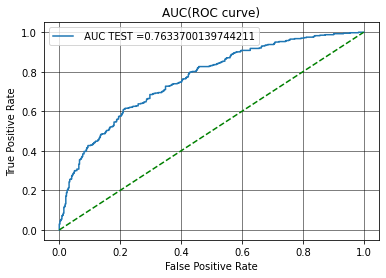

In [ ]:
############################################### Train, validaiton, test ###############################################################
############################################### Train, validaiton, test ###############################################################
############################################### Train, validaiton, test ###############################################################
average_validation = 0
average_test = 0
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
gamma = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 'scale']

for i in range(0, k_fold):
  print('Model_'+ str(i+1))
  ###############################################################################################################
  train_labels = np.zeros((len(dist_train[str(i + 1)]), 1))
  val_labels = np.zeros((len(dist_validation[str(i + 1)]), 1))
  test_labels = np.zeros((len(dist_test[str(i + 1)]), 1))

  train_images = data[str(i+1)][dist_train[str(i+1)],:]
  train_labels = labels[dist_train[str(i + 1)]]
  val_images =  data[str(i+1)][dist_validation[str(i+1)],:]
  val_labels = labels[dist_validation[str(i + 1)]]
  test_images =  data[str(i+1)][dist_test[str(i+1)],:]
  test_labels = labels[dist_test[str(i + 1)]]

  val_special_accuracy = 0
  c_best = 0
  gamma_best=0
  for c_each in C:
    for gamma_each in gamma:
      model_grid = svm.SVC(kernel='rbf', C=c_each, probability=True, random_state=0, gamma=gamma_each)
      model_grid.fit(train_images,train_labels)
      val_results = model_grid.predict(val_images)
      val_accuracy = metrics.accuracy_score(val_labels, val_results)
      # print(val_accuracy)
      if val_special_accuracy<=val_accuracy:
        val_special_accuracy = val_accuracy 
        c_best = c_each
        gamma_best = gamma_each 
  print('The proper C is: ', c_best)
  print('The proper gamma is: ', gamma_best)

  model = svm.SVC(kernel='rbf', C=c_best, probability=True, random_state=0, gamma=gamma_best)
  model.fit(train_images,train_labels)
  val_results = model.predict(val_images)
  val_results_prob = model.predict_proba(val_images)
  test_results = model.predict(test_images)
  test_results_prob = model.predict_proba(test_images)
  joblib.dump(model, save_path + 'SVM_'+str(i+1)+'.m')

  val_accuracy = metrics.accuracy_score(val_labels, val_results)
  test_accuracy = metrics.accuracy_score(test_labels, test_results)
  if i == 0:
    test_labels_concat = test_labels
    test_results_prob_concat = test_results_prob
  else:
    test_labels_concat = np.concatenate((test_labels_concat, test_labels),axis = 0)
    test_results_prob_concat = np.concatenate((test_results_prob_concat, test_results_prob),axis = 0)

  average_validation = val_accuracy * len(val_results) + average_validation
  average_test = average_test + test_accuracy * len(test_results)
  
  print('validation' + ': accuracy : {:.8f}\t'.format(
          val_accuracy))
  print('test'+ ': accuracy : {:.8f}\t'.format(
        test_accuracy))
  print('The number of samples in test set is: ', len(test_results))

average_validation = average_validation / (number_samples - len(useless_samples))
average_test = average_test / (number_samples - len(useless_samples))
print('\n')
print('The average validation is : ', average_validation)
print('The average test is : ', average_test)

test_fpr, test_tpr, te_thresholds = roc_curve(test_labels_concat, test_results_prob_concat[:,1],pos_label=1)
test_auc = auc(test_fpr, test_tpr)
print('The test AUC is: ',test_auc)
print('\n')
print('\n')
plt.grid()
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()



Ensemble  1
Fitting estimator with 19900 features.


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19900 features.
Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19900 features.
Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17

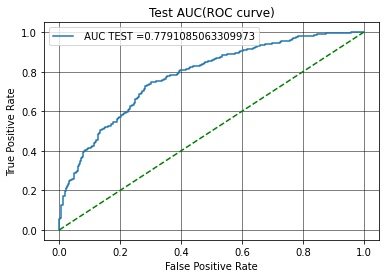

In [ ]:
############################################### Max voting ###############################################################
############################################### Max voting ###############################################################
############################################### Max voting ###############################################################
dist_ensemble_val_label = {}
dist_ensemble_val_result = {}
dist_ensemble_test_label = {}
dist_ensemble_test_result = {}
dist_ensemble_test_prob = {}

C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
gamma = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 'scale']

for ensemble_fold in range(5):
  print('Ensemble ',ensemble_fold+1)
  save_ensemble_models_path = save_path + 'Max_voting/SVM/'
  dist_train = {}
  dist_validation = {}
  dist_test = {}
  for i in range(k_fold):
    dist_train[str(i + 1)] = []
    dist_validation[str(i + 1)] = []
    dist_test[str(i + 1)] = []
  test_name = {}
  for i in range(len(unique_sites)):
    test_name[unique_sites[i]] = []
  for each_site in unique_sites:
    index_site = get_index(sites, each_site)
    label = np.zeros((len(index_site)))
    for i in range(len(index_site)):
      index = index_site[i]
      label[i] = int(labels[int(index)])
    test_name_list = test_name[each_site]
    ########################################### StratifiedKFold ####################################################
    sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
    group = 0
    for train, validation in sfolder.split(index_site,label):
      if group == ensemble_fold:
        for j in validation:
          name = index_site[j]
          dist_test['1'].append(name)
          dist_test['2'].append(name)
          dist_test['3'].append(name)
          dist_test['4'].append(name)
          dist_test['5'].append(name)
          test_name_list.append(name)
      group = group + 1
    test_name[each_site] = test_name_list

  for each_site in unique_sites:
    if ensemble_fold == 0:

      index_site = get_index(sites, each_site)
      label = np.zeros((len(index_site)))
      for i in range(len(index_site)):
        index = index_site[i]
        label[i] = int(labels[int(index)])
      test_name_list = test_name[each_site]
      index_site_new = []
      label_new = np.zeros((len(index_site) - len(test_name_list)))
      position = 0
      for x in range(len(index_site)):
        sample_name = index_site[x]
        if sample_name in test_name_list:
          c=0
        else:
          index_site_new.append(sample_name)
          label_new[position] = label[x]
          position = position + 1
      if each_site == 'CMU':  # ONLY 4 AUTISM SAMPLES AND 4 TD SAMPLES, CAN NOT BE DEVIDED INTO 5 GROUPS
        group_autism_val = []
        group_autism_train = []
        group_TD_val = []
        group_TD_train = []
        autism_validation_number = len(label_new[label_new ==1])/4
        TD_validation_number = len(label_new[label_new ==0]) / 4
        for j in range(len(label_new)):
          if label_new[j] == 1:
            if len(group_autism_val)<autism_validation_number:
              group_autism_val.append(index_site_new[j])
            else:
              group_autism_train.append(index_site_new[j])
          else:
            if len(group_TD_val)<TD_validation_number:
              group_TD_val.append(index_site_new[j])
            else:
              group_TD_train.append(index_site_new[j])

        dist_validation['1'] = dist_validation['1'] + group_autism_val + group_TD_val
        dist_validation['2'] = dist_validation['2'] + group_autism_val + group_TD_val
        dist_validation['3'] = dist_validation['3'] + group_autism_val + group_TD_val
        dist_validation['4'] = dist_validation['4'] + group_autism_val + group_TD_val
        dist_validation['5'] = dist_validation['5'] + group_autism_val + group_TD_val
        dist_train['1'] = dist_train['1'] + group_autism_train + group_TD_train
        dist_train['2'] = dist_train['2'] + group_autism_train + group_TD_train
        dist_train['3'] = dist_train['3'] + group_autism_train + group_TD_train
        dist_train['4'] = dist_train['4'] + group_autism_train + group_TD_train
        dist_train['5'] = dist_train['5'] + group_autism_train + group_TD_train
      else:
        ########################################### StratifiedKFold ####################################################
        sfolder = StratifiedKFold(n_splits=k_fold, random_state=0, shuffle=True)
        group = 0
        for train, validation in sfolder.split(index_site_new, label_new):

          for i in train:
            name = index_site_new[i]
            dist_train[str(group + 1)].append(name)
          for j in validation:
            name = index_site_new[j]
            dist_validation[str(group + 1)].append(name)
          group = group + 1
    else:

      index_site = get_index(sites, each_site)
      label = np.zeros((len(index_site)))
      for i in range(len(index_site)):
        index = index_site[i]
        label[i] = int(labels[int(index)])
      test_name_list = test_name[each_site]
      index_site_new = []
      label_new = np.zeros((len(index_site) - len(test_name_list)))
      position = 0
      for x in range(len(index_site)):
        sample_name = index_site[x]
        if sample_name in test_name_list:
          c=0
        else:
          index_site_new.append(sample_name)
          label_new[position] = label[x]
          position = position + 1
      ########################################### StratifiedKFold ####################################################
      sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
      group = 0
      for train, validation in sfolder.split(index_site_new,label_new):

        for i in train:
          name = index_site_new[i]
          dist_train[str(group + 1)].append(name)
        for j in validation:
          name = index_site_new[j]
          dist_validation[str(group + 1)].append(name)
        group = group+1
  


  data = {}
  for fold in range(1, k_fold+1):
    selector_fMRI = feature_selection_fMRI(fMRI_images, labels, dist_train[str(fold)], new_number_features_fMRI)
    selector_sMRI = feature_selection_sMRI(sMRI_features, labels, dist_train[str(fold)], new_number_features_sMRI)

    new_fMRI_data = selector_fMRI.transform(fMRI_images)
    new_sMRI_data = selector_sMRI.transform(sMRI_features)
    ################################################# combine ##########################################
    sMRI_fMRI_combine = np.concatenate((new_sMRI_data, new_fMRI_data), axis = 1)
    selector_combine = feature_selection_fMRI(sMRI_fMRI_combine, labels, dist_train[str(fold)], new_number_features_combine)
    data[str(fold)] = selector_combine.transform(sMRI_fMRI_combine)

  ############################################### Train, validaiton, test ###############################################################
  ############################################### Train, validaiton, test ###############################################################
  ############################################### Train, validaiton, test ###############################################################
  val_special_accuracy = 0

  for c_each in C:
    for gamma_each in gamma:
      number_val = 0
      number_test = 0
      fold_validation = []
      fold_test = []
      fold_models = []
      for fold in range(0, k_fold):

        ###############################################################################################################
        model = svm.SVC(kernel='rbf', C=c_each, probability=True, random_state=0, gamma=gamma_each)
        train_labels = np.zeros((len(dist_train[str(fold + 1)]), 1))
        val_labels = np.zeros((len(dist_validation[str(fold + 1)]), 1))
        test_labels = np.zeros((len(dist_test[str(fold + 1)]), 1))

        train_images = data[str(fold+1)][dist_train[str(fold+1)],:]
        train_labels = labels[dist_train[str(fold + 1)]]
        val_images =  data[str(fold+1)][dist_validation[str(fold+1)],:]
        val_labels = labels[dist_validation[str(fold + 1)]]
        test_images =  data[str(fold+1)][dist_test[str(fold+1)],:]
        test_labels = labels[dist_test[str(fold + 1)]]

        model.fit(train_images,train_labels)
        
        val_results = model.predict(val_images)
        val_accuracy = metrics.accuracy_score(val_labels, val_results)
        number_val = number_val + len(val_results)
        fold_validation.append(val_accuracy * len(val_results))

        test_results = model.predict(test_images)
        test_accuracy = metrics.accuracy_score(test_labels, test_results)
        test_results_prob = model.predict_proba(test_images)
        number_test = number_test + len(test_results)
        fold_test.append(test_accuracy * len(test_results))

        fold_models.append(model)

        if fold == 0:
          test_results_plus = test_results
          test_results_prob_plus = test_results_prob
        else:
          test_results_plus = test_results_plus + test_results
          test_results_prob_plus = test_results_prob_plus + test_results_prob

      average_validation = sum(fold_validation)/number_val
      average_test = sum(fold_test)/number_test

      if val_special_accuracy <= average_validation:
        val_special_accuracy = average_validation 
        c_best = c_each
        gamma_best = gamma_each
        corresponding_test_accuracy = average_test
        corresponding_test_results_plus = test_results_plus
        corresponding_test_results_prob_plus = test_results_prob_plus
        joblib.dump(fold_models[0], save_ensemble_models_path + 'SVM_ensemble'+ str(ensemble_fold) + '_' + str(1)+'.m')
        joblib.dump(fold_models[1], save_ensemble_models_path + 'SVM_ensemble'+ str(ensemble_fold) + '_' + str(2)+'.m')
        joblib.dump(fold_models[2], save_ensemble_models_path + 'SVM_ensemble'+ str(ensemble_fold) + '_' + str(3)+'.m')
        joblib.dump(fold_models[3], save_ensemble_models_path + 'SVM_ensemble'+ str(ensemble_fold) + '_' + str(4)+'.m')
        joblib.dump(fold_models[4], save_ensemble_models_path + 'SVM_ensemble'+ str(ensemble_fold) + '_' + str(5)+'.m')
  
  print('The proper C is: ', c_best)
  print('The proper gamma is: ', gamma_best)
  print('The average validation accuracy is: ',val_special_accuracy)
  print('The average test accuracy is: ',corresponding_test_accuracy)
  print('The number of samples in test set is: ',len(test_results))
  dist_ensemble_test_label[str(ensemble_fold+1)] = test_labels
  dist_ensemble_test_result[str(ensemble_fold+1)] = corresponding_test_results_plus
  dist_ensemble_test_prob[str(ensemble_fold+1)] = corresponding_test_results_prob_plus


test_labels_concat = np.concatenate((dist_ensemble_test_label['1'], dist_ensemble_test_label['2'],  dist_ensemble_test_label['3'], dist_ensemble_test_label['4'], dist_ensemble_test_label['5']),axis = 0)
test_results_concat = np.concatenate((dist_ensemble_test_result['1'], dist_ensemble_test_result['2'],  dist_ensemble_test_result['3'], dist_ensemble_test_result['4'], dist_ensemble_test_result['5']),axis = 0)
test_probs_concat = np.concatenate((dist_ensemble_test_prob['1'], dist_ensemble_test_prob['2'],  dist_ensemble_test_prob['3'], dist_ensemble_test_prob['4'], dist_ensemble_test_prob['5']),axis = 0)

test_results_concat[test_results_concat<2.5] = 0
test_results_concat[test_results_concat>=2.5] = 1
test_probs_concat = test_probs_concat/5


test_accuracy = metrics.accuracy_score(test_labels_concat, test_results_concat)
test_fpr, test_tpr, te_thresholds = roc_curve(test_labels_concat, test_probs_concat[:,1],pos_label=1)
test_auc = auc(test_fpr, test_tpr)
print('\n')
print('The Max voting test accuracy is: ',test_accuracy)
print('The test AUC is: ',test_auc)

print('\n')
print('\n')
plt.grid()
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

